In [18]:
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

In [6]:
def get_pictures(folder):
    Images= []
    Labels = []
    label =0
    for labels in os.listdir(folder):
        if labels == 'Parasitized':
            label = 0
        elif labels == 'Uninfected':
            label =1
        for images in os.listdir(folder+labels):
            try:
                image = cv2.imread(folder+labels+r'/'+images)
                image = cv2.resize(image, (224,224))
                Images.append(image)
                Labels.append(label)
            except:
                None
    return shuffle(Images, Labels, random_state= 12863686)

def get_labels(code):
    labels = {0:'Parasitized', 1:'Uninfected'}
    
    return labels[code]

In [7]:
Images, Labels = get_pictures(r'A:\cell_images\train/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [8]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (27456, 224, 224, 3)
Shape of Labels: (27456,)


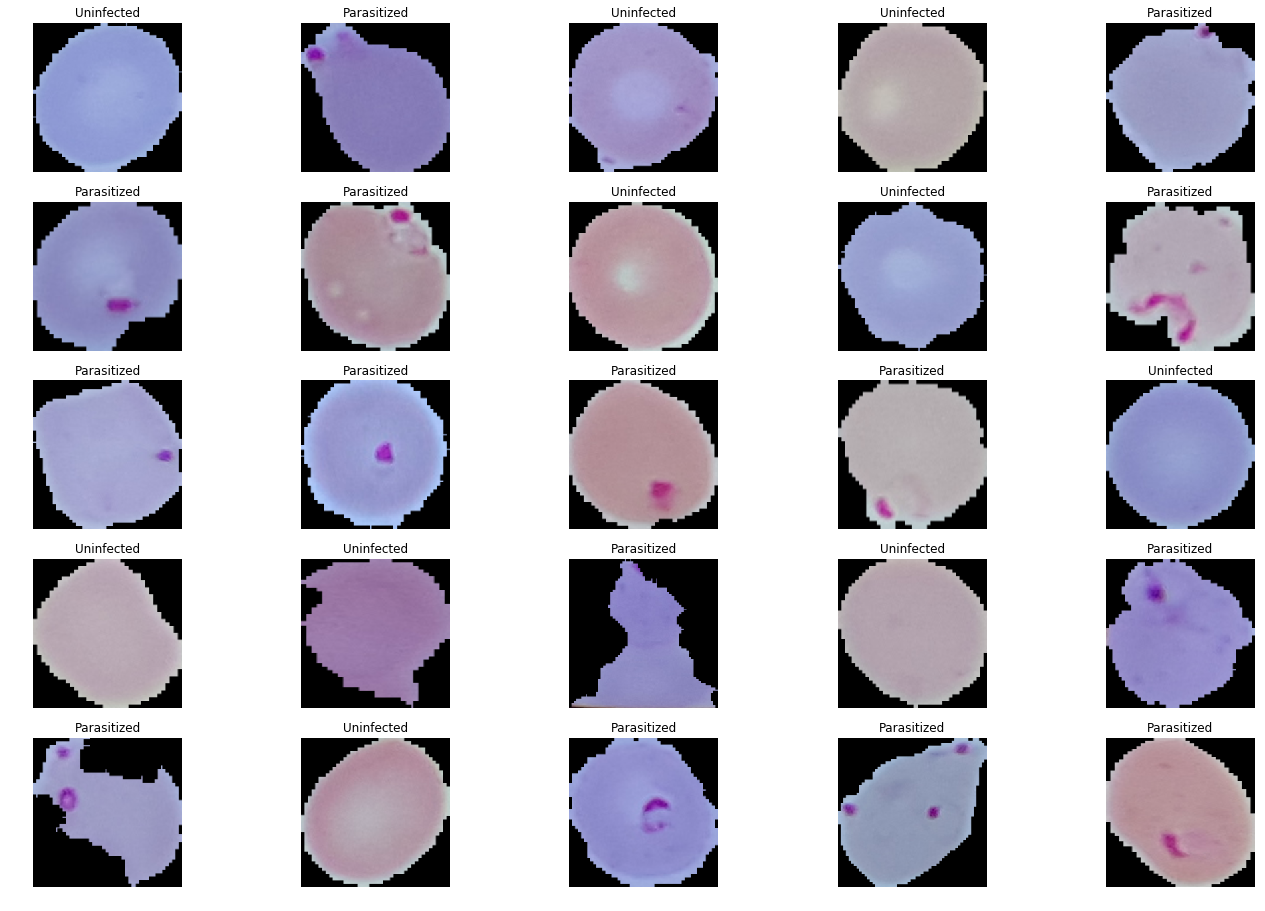

In [9]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_labels(Labels[rnd_number]))
        ax[i,j].axis('off')

In [21]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [22]:
IMAGE_SIZE = [224, 224]
tf.compat.v1.get_default_graph
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 178s 2us/step


In [23]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False


In [24]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

In [25]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [29]:
history = trained = model.fit(Images,Labels,epochs=3,validation_split=0.20)

Train on 21964 samples, validate on 5492 samples
Epoch 1/3
21964/21964 [==============================] - 7350s 335ms/sample - loss: 2.2691 - accuracy: 0.9027 - val_loss: 2.5231 - val_accuracy: 0.9306
Epoch 2/3
21964/21964 [==============================] - 6941s 316ms/sample - loss: 1.8118 - accuracy: 0.9369 - val_loss: 2.4261 - val_accuracy: 0.9326
Epoch 3/3
21964/21964 [==============================] - 7397s 337ms/sample - loss: 1.3799 - accuracy: 0.9513 - val_loss: 2.7342 - val_accuracy: 0.9392


In [31]:
model.save('model_vgg19.h5')

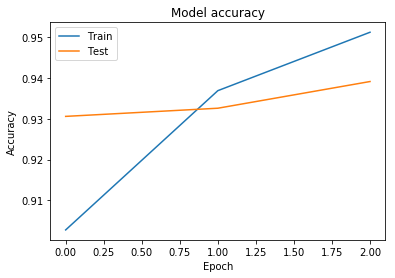

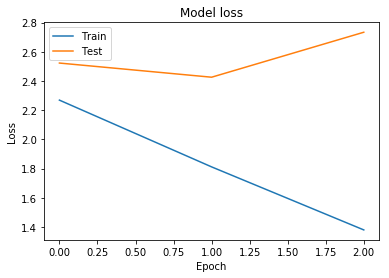

In [34]:
# #Plot the graph for accuracy and loss for better understanding
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [92]:
#use some images for model to predict them, I created a folder and stored some images for prediction
pred_images,no_labels = get_pictures(r'A:\cell_images\test/')
pred_images = np.array(pred_images)
pred_images.shape
classes = ("Parasitized, Uninfected")

In [93]:
predictions = model.predict(pred_images)

In [128]:
print(get_labels(np.argmax(predictions)))

Uninfected


C:\Users\vibhu\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


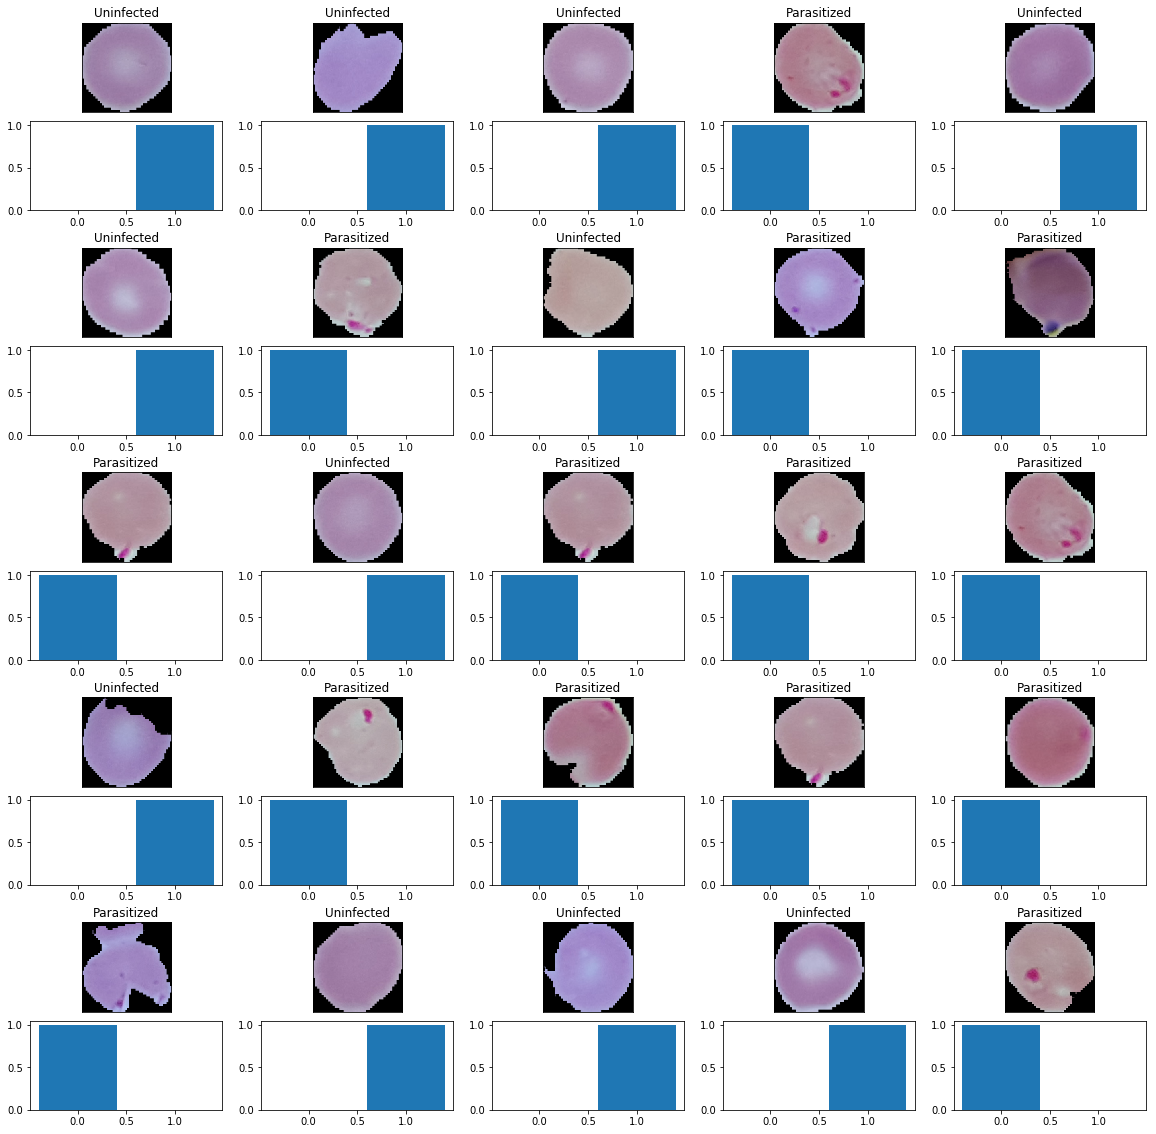

In [132]:
#visualize some images ouptput after prediction from model to see final results
fig = plot.figure(figsize=(20, 20))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_labels(np.argmax(model.predict(pred_image)[0]))
    pred_prob = model.predict(pred_image).reshape(2)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
           #ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1],pred_prob)
            fig.add_subplot(ax)


fig.show()

In [133]:
test_images,test_labels = get_pictures(r'A:\cell_images\test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)

102/102 [==============================] - 24s 238ms/sample - loss: 5.1264 - accuracy: 0.9020


[5.126419366574755, 0.9019608]